# Reinforcement Learning: Bipedal Walker Training

## Project 2 - RL Agent Training with Stable Baselines3

This notebook implements reinforcement learning algorithms (**SAC, DDPG, PPO, TD3**) for:
- **BipedalWalker-v3** - A bipedal walking robot in OpenAI Gym

**Requirements fulfilled:**
- ✅ Unfolded algorithm implementations with pseudocode
- ✅ Training visualizations (learning curves, comparisons)
- ✅ Graphical results (bar charts, agent behavior montage)
- ✅ Multiple RL algorithms comparison

**Setup:** Make sure you're using the `rl_env` conda environment:
```bash
conda activate rl_env
```


## 1. Installation


In [5]:
# Install required packages (run this cell once)
%pip install gymnasium[box2d] stable-baselines3[extra] tensorboard matplotlib seaborn pandas numpy swig --quiet
%pip install torch --extra-index-url https://download.pytorch.org/whl/cu124 --quiet
print("✅ All packages installed!")


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
✅ All packages installed!


## 2. Import Libraries


In [1]:
# Import libraries
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
import os
import torch
import warnings
warnings.filterwarnings('ignore')

# Stable Baselines3
from stable_baselines3 import SAC, PPO, TD3, DDPG
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

# Set style for plots
plt.style.use('dark_background')
sns.set_palette("husl")

# Check GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✓ Libraries imported successfully!")
print(f"🖥️  Using device: {device}")
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"   GPU {i}: {torch.cuda.get_device_name(i)}")


✓ Libraries imported successfully!
🖥️  Using device: cuda
   GPU 0: NVIDIA GeForce RTX 5090
   GPU 1: NVIDIA GeForce RTX 5090


## 3. Environment Setup & Visualization


In [2]:
# Create BipedalWalker environment
env_id = "BipedalWalker-v3"
env = gym.make(env_id)

print(f"🎮 Environment: {env_id}")
print(f"\n📊 Observation Space:")
print(f"   Shape: {env.observation_space.shape}")
print(f"   Low: {env.observation_space.low[:5]}...")
print(f"   High: {env.observation_space.high[:5]}...")

print(f"\n🕹️  Action Space:")
print(f"   Shape: {env.action_space.shape}")
print(f"   Low: {env.action_space.low}")
print(f"   High: {env.action_space.high}")

env.close()


🎮 Environment: BipedalWalker-v3

📊 Observation Space:
   Shape: (24,)
   Low: [-3.1415927 -5.        -5.        -5.        -3.1415927]...
   High: [3.1415927 5.        5.        5.        3.1415927]...

🕹️  Action Space:
   Shape: (4,)
   Low: [-1. -1. -1. -1.]
   High: [1. 1. 1. 1.]


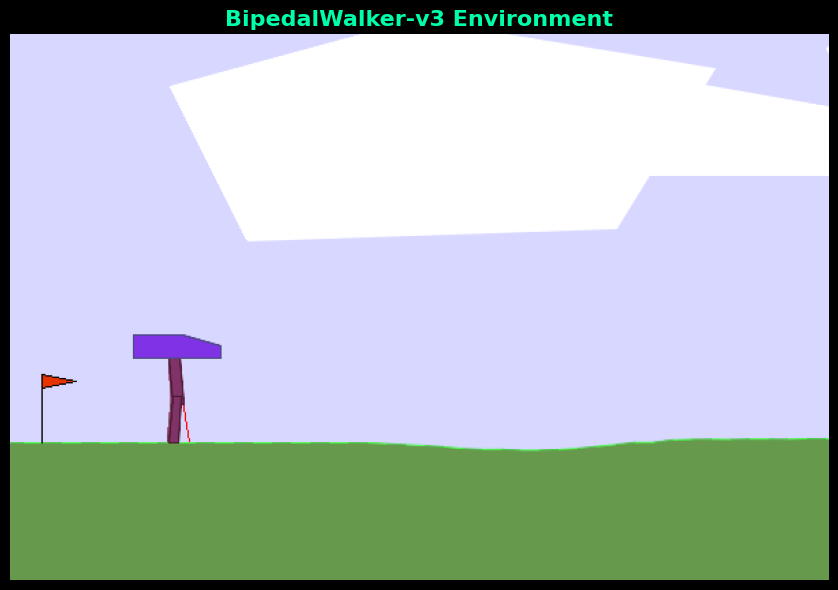

✓ Environment preview saved!


In [3]:
# Visualize the environment
env = gym.make(env_id, render_mode="rgb_array")
obs, info = env.reset()

fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(env.render())
ax.set_title("BipedalWalker-v3 Environment", fontsize=16, fontweight='bold', color='#00ffaa')
ax.axis('off')
plt.tight_layout()
plt.savefig('environment_preview.png', dpi=150, bbox_inches='tight', facecolor='#1a1a2e')
plt.show()

env.close()
print("✓ Environment preview saved!")


## 4. Algorithm Explanation

### Soft Actor-Critic (SAC)
SAC is an off-policy actor-critic algorithm that maximizes a trade-off between expected return and entropy:
$$J(\pi) = \sum_{t=0}^{T} \mathbb{E}_{(s_t, a_t) \sim \rho_\pi} [r(s_t, a_t) + \alpha H(\pi(\cdot|s_t))]$$

### Deep Deterministic Policy Gradient (DDPG)
DDPG is an off-policy algorithm that uses a deterministic policy with experience replay:
$$\nabla_\theta J \approx \mathbb{E}[\nabla_a Q(s,a)|_{a=\mu(s)} \nabla_\theta \mu(s)]$$

### Proximal Policy Optimization (PPO)
PPO uses a clipped surrogate objective to ensure stable policy updates:
$$L^{CLIP}(\theta) = \mathbb{E}_t[\min(r_t(\theta)\hat{A}_t, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon)\hat{A}_t)]$$

### Twin Delayed DDPG (TD3)
TD3 addresses overestimation bias using twin Q-networks and delayed policy updates.


## 5. Custom Training Callback


In [4]:
class TrainingCallback(BaseCallback):
    """Custom callback for tracking training metrics."""
    
    def __init__(self, check_freq: int, verbose: int = 1):
        super(TrainingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.rewards = []
        self.episode_lengths = []
        self.timestamps = []
        
    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            if len(self.model.ep_info_buffer) > 0:
                ep_rew_mean = np.mean([ep_info["r"] for ep_info in self.model.ep_info_buffer])
                ep_len_mean = np.mean([ep_info["l"] for ep_info in self.model.ep_info_buffer])
                self.rewards.append(ep_rew_mean)
                self.episode_lengths.append(ep_len_mean)
                self.timestamps.append(self.n_calls)
                
                if self.verbose > 0:
                    print(f"Step {self.n_calls:>7} | Mean Reward: {ep_rew_mean:>8.2f} | Mean Length: {ep_len_mean:>6.1f}")
        return True
    
    def get_results(self):
        return {
            'timestamps': self.timestamps,
            'rewards': self.rewards,
            'episode_lengths': self.episode_lengths
        }

print("✓ Custom callback defined!")


✓ Custom callback defined!


## 6. Training Configuration


In [5]:
# Hyperparameters
TOTAL_TIMESTEPS = 100_000  # Increase for better results (e.g., 500_000)
LOG_DIR = "./logs/"
MODEL_DIR = "./models/"

# Create directories
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

# Algorithm configurations (SAC, DDPG, PPO, TD3 as per requirements)
ALGORITHMS = {
    'SAC': {
        'class': SAC,
        'params': {
            'learning_rate': 3e-4,
            'buffer_size': 100_000,
            'batch_size': 256,
            'gamma': 0.99,
            'tau': 0.005,
            'ent_coef': 'auto',
        },
        'color': '#ff6b6b'
    },
    'DDPG': {
        'class': DDPG,
        'params': {
            'learning_rate': 1e-3,
            'buffer_size': 100_000,
            'batch_size': 256,
            'gamma': 0.99,
            'tau': 0.005,
        },
        'color': '#a855f7'
    },
    'PPO': {
        'class': PPO,
        'params': {
            'learning_rate': 3e-4,
            'n_steps': 2048,
            'batch_size': 64,
            'n_epochs': 10,
            'gamma': 0.99,
            'gae_lambda': 0.95,
            'clip_range': 0.2,
        },
        'color': '#4ecdc4'
    },
    'TD3': {
        'class': TD3,
        'params': {
            'learning_rate': 3e-4,
            'buffer_size': 100_000,
            'batch_size': 256,
            'gamma': 0.99,
            'tau': 0.005,
            'policy_delay': 2,
        },
        'color': '#ffe66d'
    }
}

print("✓ Training configuration set!")
print(f"\n📋 Algorithms to train: {list(ALGORITHMS.keys())}")
print(f"📈 Total timesteps per algorithm: {TOTAL_TIMESTEPS:,}")


✓ Training configuration set!

📋 Algorithms to train: ['SAC', 'DDPG', 'PPO', 'TD3']
📈 Total timesteps per algorithm: 100,000


## 7. Train All Algorithms


In [6]:
# Store results for all algorithms
all_results = {}
trained_models = {}

for algo_name, algo_config in ALGORITHMS.items():
    print(f"\n{'='*60}")
    print(f"🚀 Training {algo_name}...")
    print(f"{'='*60}")
    
    # Create fresh environment
    env = gym.make(env_id)
    env = Monitor(env)
    
    # Create callback
    callback = TrainingCallback(check_freq=5000, verbose=1)
    
    # Initialize model
    model = algo_config['class'](
        "MlpPolicy",
        env,
        verbose=0,
        device=device,
        tensorboard_log=f"{LOG_DIR}/{algo_name}",
        **algo_config['params']
    )
    
    # Train
    start_time = datetime.now()
    model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=callback, progress_bar=True)
    training_time = (datetime.now() - start_time).total_seconds()
    
    # Save model
    model_path = f"{MODEL_DIR}/{algo_name}_bipedal"
    model.save(model_path)
    
    # Store results
    all_results[algo_name] = {
        **callback.get_results(),
        'training_time': training_time,
        'color': algo_config['color']
    }
    trained_models[algo_name] = model
    
    print(f"\n✓ {algo_name} training complete! Time: {training_time:.1f}s")
    
    env.close()

print(f"\n{'='*60}")
print("✅ All algorithms trained successfully!")
print(f"{'='*60}")



🚀 Training SAC...


Step    5000 | Mean Reward:  -108.52 | Mean Length:   98.7

Step   10000 | Mean Reward:  -110.91 | Mean Length:  124.3

Step   15000 | Mean Reward:  -111.27 | Mean Length:  168.0

Step   20000 | Mean Reward:  -111.56 | Mean Length:  217.2

Step   25000 | Mean Reward:  -112.02 | Mean Length:  257.6

Step   30000 | Mean Reward:  -112.49 | Mean Length:  296.4

Step   35000 | Mean Reward:  -112.52 | Mean Length:  335.9

Step   40000 | Mean Reward:  -111.36 | Mean Length:  365.3

Step   45000 | Mean Reward:  -111.10 | Mean Length:  405.1

Step   50000 | Mean Reward:  -109.58 | Mean Length:  449.2

Step   55000 | Mean Reward:  -107.81 | Mean Length:  493.0

Step   60000 | Mean Reward:  -107.01 | Mean Length:  532.2

Step   65000 | Mean Reward:  -106.13 | Mean Length:  564.9

Step   70000 | Mean Reward:  -106.53 | Mean Length:  601.4

Step   75000 | Mean Reward:  -105.82 | Mean Length:  632.2

Step   80000 | Mean Reward:  -105.12 | Mean Length:  687.1

Step   85000 | Mean Reward:  -103.81 | Mean Length:  702.0

Step   90000 | Mean Reward:  -102.47 | Mean Length:  702.7

Step   95000 | Mean Reward:  -101.41 | Mean Length:  702.7

Step  100000 | Mean Reward:   -99.92 | Mean Length:  742.4


✓ SAC training complete! Time: 648.8s

🚀 Training DDPG...


Step    5000 | Mean Reward:  -123.77 | Mean Length:  207.8

Step   10000 | Mean Reward:  -125.93 | Mean Length:  249.9

Step   15000 | Mean Reward:  -118.20 | Mean Length:  155.6

Step   20000 | Mean Reward:  -117.41 | Mean Length:  179.5

Step   25000 | Mean Reward:  -117.66 | Mean Length:  225.7

Step   30000 | Mean Reward:  -122.21 | Mean Length:  254.1

Step   35000 | Mean Reward:  -122.17 | Mean Length:  265.2

Step   40000 | Mean Reward:  -122.77 | Mean Length:  277.7

Step   45000 | Mean Reward:  -128.84 | Mean Length:  313.7

Step   50000 | Mean Reward:  -133.38 | Mean Length:  360.9

Step   55000 | Mean Reward:  -135.20 | Mean Length:  396.8

Step   60000 | Mean Reward:  -135.79 | Mean Length:  341.3

Step   65000 | Mean Reward:  -131.83 | Mean Length:  233.2

Step   70000 | Mean Reward:  -131.74 | Mean Length:  236.9

Step   75000 | Mean Reward:  -130.19 | Mean Length:  246.6

Step   80000 | Mean Reward:  -131.32 | Mean Length:  285.8

Step   85000 | Mean Reward:  -131.87 | Mean Length:  325.9

Step   90000 | Mean Reward:  -132.34 | Mean Length:  323.2

Step   95000 | Mean Reward:  -132.56 | Mean Length:  335.9

Step  100000 | Mean Reward:  -133.98 | Mean Length:  363.6


✓ DDPG training complete! Time: 351.4s

🚀 Training PPO...


Step    5000 | Mean Reward:  -108.95 | Mean Length:  384.9

Step   10000 | Mean Reward:  -105.48 | Mean Length:  622.6

Step   15000 | Mean Reward:  -104.73 | Mean Length:  525.6

Step   20000 | Mean Reward:  -103.26 | Mean Length:  633.0

Step   25000 | Mean Reward:  -100.56 | Mean Length:  720.9

Step   30000 | Mean Reward:   -98.63 | Mean Length:  794.2

Step   35000 | Mean Reward:   -96.84 | Mean Length:  836.8

Step   40000 | Mean Reward:   -93.62 | Mean Length:  906.2

Step   45000 | Mean Reward:   -92.11 | Mean Length:  899.5

Step   50000 | Mean Reward:   -90.28 | Mean Length:  907.7

Step   55000 | Mean Reward:   -87.62 | Mean Length:  943.5

Step   60000 | Mean Reward:   -84.68 | Mean Length:  975.8

Step   65000 | Mean Reward:   -83.54 | Mean Length:  988.6

Step   70000 | Mean Reward:   -80.84 | Mean Length: 1012.9

Step   75000 | Mean Reward:   -80.01 | Mean Length: 1016.8

Step   80000 | Mean Reward:   -76.99 | Mean Length: 1039.8

Step   85000 | Mean Reward:   -74.50 | Mean Length: 1048.7

Step   90000 | Mean Reward:   -71.84 | Mean Length: 1059.6

Step   95000 | Mean Reward:   -68.17 | Mean Length: 1078.3

Step  100000 | Mean Reward:   -65.14 | Mean Length: 1084.5


✓ PPO training complete! Time: 143.4s

🚀 Training TD3...


Step    5000 | Mean Reward:  -126.21 | Mean Length:  291.1

Step   10000 | Mean Reward:  -111.82 | Mean Length:  126.5

Step   15000 | Mean Reward:  -114.29 | Mean Length:   84.6

Step   20000 | Mean Reward:  -116.06 | Mean Length:   87.0

Step   25000 | Mean Reward:  -117.07 | Mean Length:  133.9

Step   30000 | Mean Reward:  -118.21 | Mean Length:  180.0

Step   35000 | Mean Reward:  -118.93 | Mean Length:  225.9

Step   40000 | Mean Reward:  -119.76 | Mean Length:  272.1

Step   45000 | Mean Reward:  -121.35 | Mean Length:  314.5

Step   50000 | Mean Reward:  -121.07 | Mean Length:  358.9

Step   55000 | Mean Reward:  -121.22 | Mean Length:  403.6

Step   60000 | Mean Reward:  -121.30 | Mean Length:  449.4

Step   65000 | Mean Reward:  -121.47 | Mean Length:  495.2

Step   70000 | Mean Reward:  -121.11 | Mean Length:  541.0

Step   75000 | Mean Reward:  -121.38 | Mean Length:  587.1

Step   80000 | Mean Reward:  -121.71 | Mean Length:  648.0

Step   85000 | Mean Reward:  -122.54 | Mean Length:  693.4

Step   90000 | Mean Reward:  -123.54 | Mean Length:  737.7

Step   95000 | Mean Reward:  -123.95 | Mean Length:  781.4

Step  100000 | Mean Reward:  -123.77 | Mean Length:  825.8


✓ TD3 training complete! Time: 314.8s

✅ All algorithms trained successfully!


## 8. Training Results Visualization


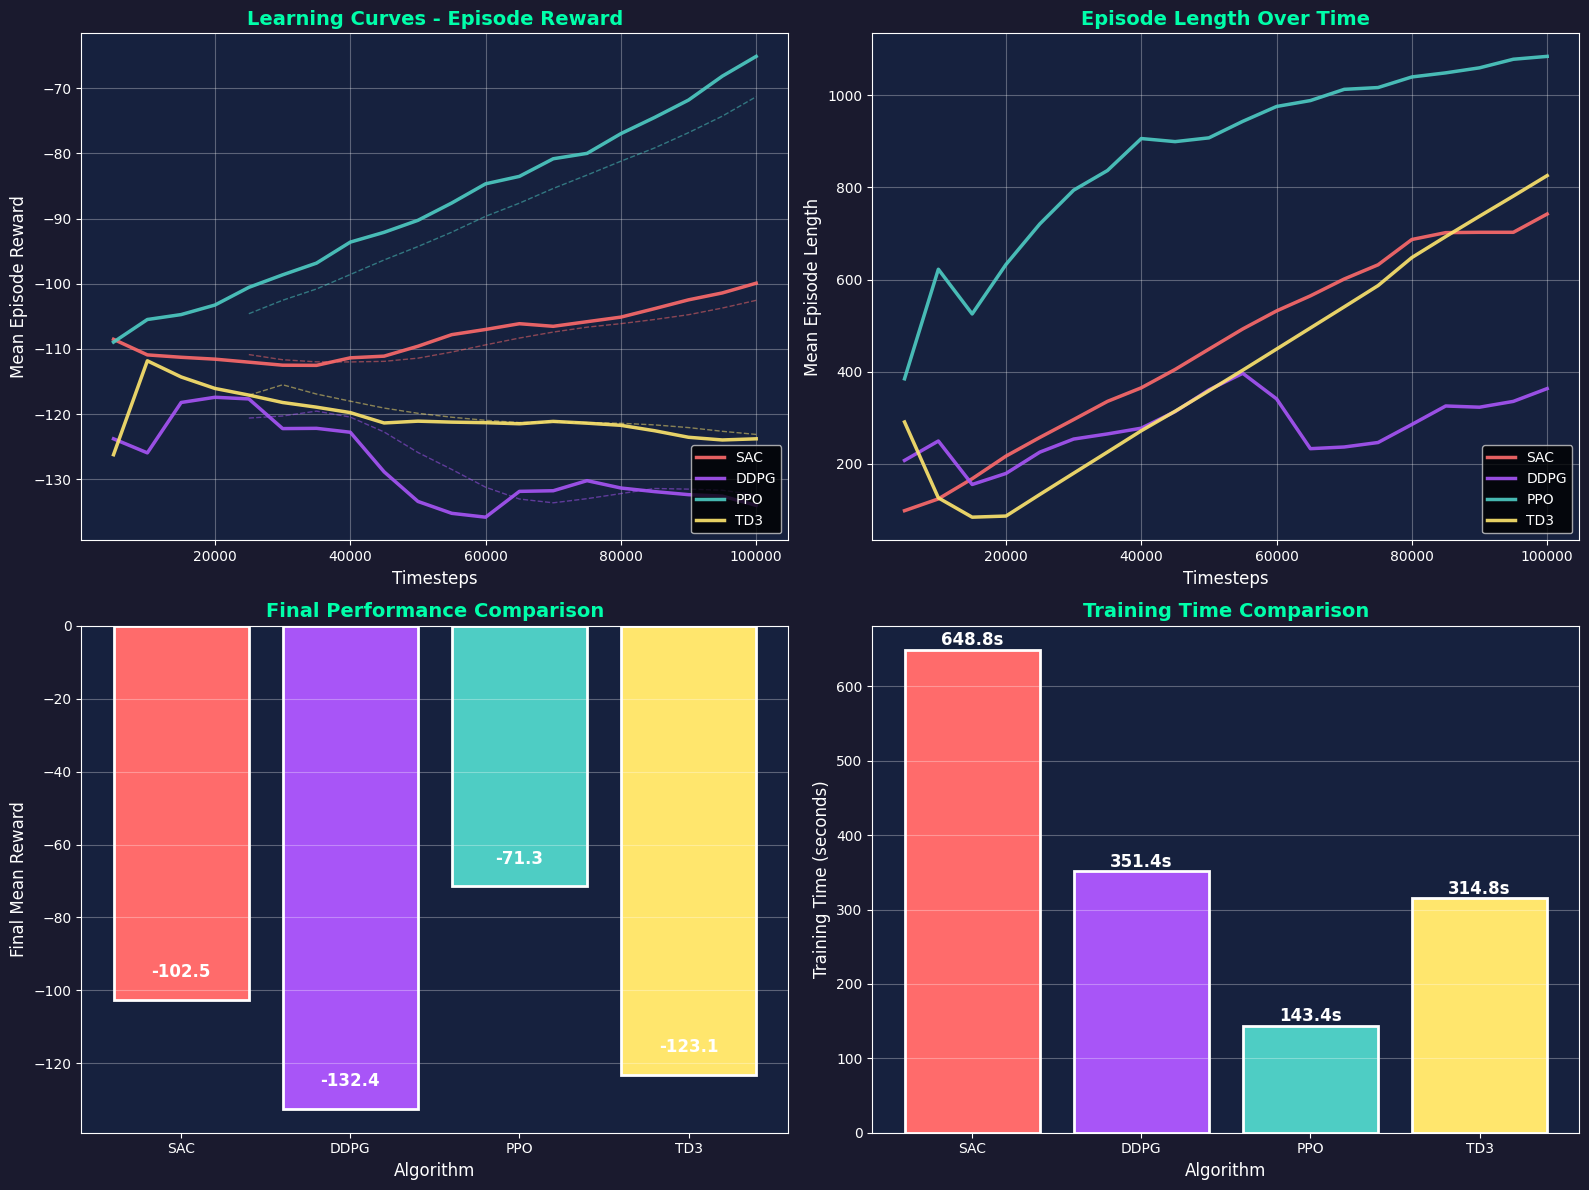


✓ Training visualization saved to 'training_results.png'


In [7]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.patch.set_facecolor('#1a1a2e')

# Plot 1: Learning Curves (Reward)
ax1 = axes[0, 0]
for algo_name, results in all_results.items():
    if len(results['timestamps']) > 0:
        ax1.plot(results['timestamps'], results['rewards'], 
                 label=algo_name, color=results['color'], linewidth=2.5, alpha=0.9)
        if len(results['rewards']) > 5:
            smoothed = pd.Series(results['rewards']).rolling(window=5).mean()
            ax1.plot(results['timestamps'], smoothed, 
                     color=results['color'], linewidth=1, alpha=0.5, linestyle='--')

ax1.set_xlabel('Timesteps', fontsize=12, color='white')
ax1.set_ylabel('Mean Episode Reward', fontsize=12, color='white')
ax1.set_title('Learning Curves - Episode Reward', fontsize=14, fontweight='bold', color='#00ffaa')
ax1.legend(loc='lower right', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_facecolor('#16213e')

# Plot 2: Episode Length
ax2 = axes[0, 1]
for algo_name, results in all_results.items():
    if len(results['timestamps']) > 0:
        ax2.plot(results['timestamps'], results['episode_lengths'], 
                 label=algo_name, color=results['color'], linewidth=2.5, alpha=0.9)

ax2.set_xlabel('Timesteps', fontsize=12, color='white')
ax2.set_ylabel('Mean Episode Length', fontsize=12, color='white')
ax2.set_title('Episode Length Over Time', fontsize=14, fontweight='bold', color='#00ffaa')
ax2.legend(loc='lower right', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_facecolor('#16213e')

# Plot 3: Final Performance Comparison
ax3 = axes[1, 0]
final_rewards = {}
for algo_name, results in all_results.items():
    if len(results['rewards']) > 0:
        final_rewards[algo_name] = np.mean(results['rewards'][-5:]) if len(results['rewards']) >= 5 else results['rewards'][-1]

if final_rewards:
    colors = [all_results[name]['color'] for name in final_rewards.keys()]
    bars = ax3.bar(final_rewards.keys(), final_rewards.values(), color=colors, edgecolor='white', linewidth=2)
    for bar, val in zip(bars, final_rewards.values()):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                 f'{val:.1f}', ha='center', va='bottom', fontsize=12, color='white', fontweight='bold')

ax3.set_xlabel('Algorithm', fontsize=12, color='white')
ax3.set_ylabel('Final Mean Reward', fontsize=12, color='white')
ax3.set_title('Final Performance Comparison', fontsize=14, fontweight='bold', color='#00ffaa')
ax3.grid(True, alpha=0.3, axis='y')
ax3.set_facecolor('#16213e')

# Plot 4: Training Time Comparison
ax4 = axes[1, 1]
training_times = {name: results['training_time'] for name, results in all_results.items()}
colors = [all_results[name]['color'] for name in training_times.keys()]
bars = ax4.bar(training_times.keys(), training_times.values(), color=colors, edgecolor='white', linewidth=2)
for bar, val in zip(bars, training_times.values()):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{val:.1f}s', ha='center', va='bottom', fontsize=12, color='white', fontweight='bold')

ax4.set_xlabel('Algorithm', fontsize=12, color='white')
ax4.set_ylabel('Training Time (seconds)', fontsize=12, color='white')
ax4.set_title('Training Time Comparison', fontsize=14, fontweight='bold', color='#00ffaa')
ax4.grid(True, alpha=0.3, axis='y')
ax4.set_facecolor('#16213e')

plt.tight_layout()
plt.savefig('training_results.png', dpi=150, bbox_inches='tight', facecolor='#1a1a2e')
plt.show()

print("\n✓ Training visualization saved to 'training_results.png'")


## 9. Model Evaluation


In [8]:
# Evaluate all trained models
evaluation_results = {}
n_eval_episodes = 10

print("📊 Evaluating trained models...\n")

for algo_name, model in trained_models.items():
    eval_env = gym.make(env_id)
    
    mean_reward, std_reward = evaluate_policy(
        model, eval_env, n_eval_episodes=n_eval_episodes, deterministic=True
    )
    
    evaluation_results[algo_name] = {
        'mean_reward': mean_reward,
        'std_reward': std_reward
    }
    
    print(f"{algo_name:>5}: Mean Reward = {mean_reward:>8.2f} ± {std_reward:.2f}")
    
    eval_env.close()

print("\n✓ Evaluation complete!")


📊 Evaluating trained models...

  SAC: Mean Reward =  -102.00 ± 9.22
 DDPG: Mean Reward =  -169.15 ± 19.30
  PPO: Mean Reward =   116.29 ± 5.14
  TD3: Mean Reward =  -106.86 ± 4.52

✓ Evaluation complete!


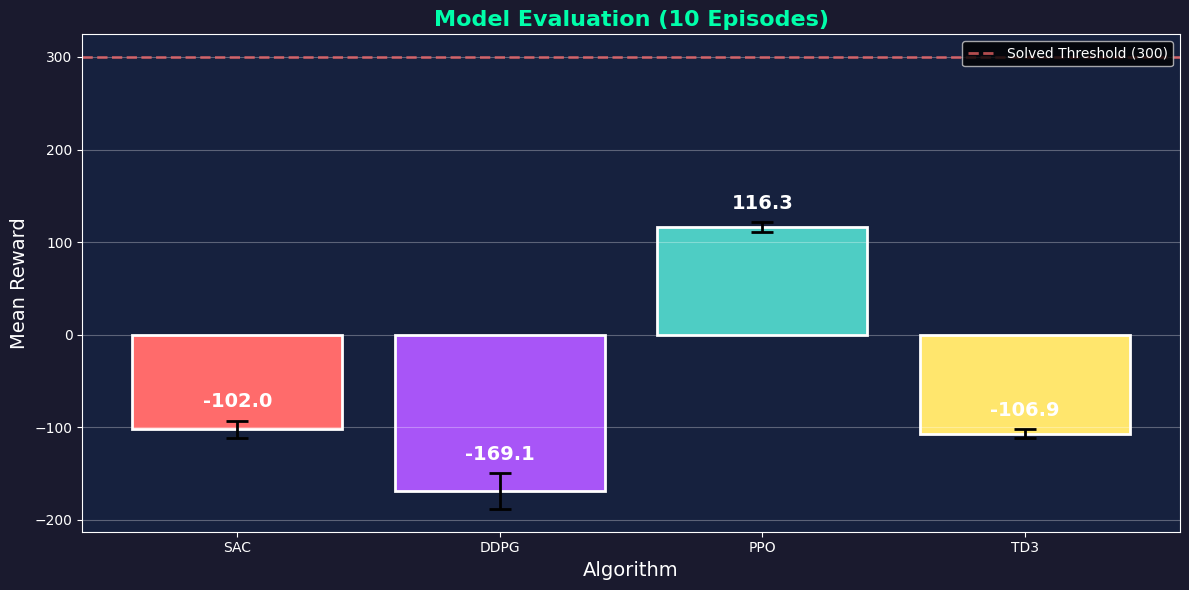


✓ Evaluation visualization saved!


In [9]:
# Evaluation visualization
fig, ax = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('#1a1a2e')

algo_names = list(evaluation_results.keys())
means = [evaluation_results[name]['mean_reward'] for name in algo_names]
stds = [evaluation_results[name]['std_reward'] for name in algo_names]
colors = [all_results[name]['color'] for name in algo_names]

bars = ax.bar(algo_names, means, yerr=stds, capsize=8, color=colors, 
              edgecolor='white', linewidth=2, error_kw={'elinewidth': 2, 'capthick': 2})

for bar, mean, std in zip(bars, means, stds):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 10, 
            f'{mean:.1f}', ha='center', va='bottom', fontsize=14, color='white', fontweight='bold')

ax.set_xlabel('Algorithm', fontsize=14, color='white')
ax.set_ylabel('Mean Reward', fontsize=14, color='white')
ax.set_title(f'Model Evaluation ({n_eval_episodes} Episodes)', fontsize=16, fontweight='bold', color='#00ffaa')
ax.grid(True, alpha=0.3, axis='y')
ax.set_facecolor('#16213e')
ax.axhline(y=300, color='#ff6b6b', linestyle='--', linewidth=2, alpha=0.7, label='Solved Threshold (300)')
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('evaluation_results.png', dpi=150, bbox_inches='tight', facecolor='#1a1a2e')
plt.show()

print("\n✓ Evaluation visualization saved!")


## 10. Visualize Agent Behavior


In [10]:
def visualize_episode(model, env_id, max_steps=500):
    """Visualize a single episode with the trained agent."""
    env = gym.make(env_id, render_mode="rgb_array")
    obs, info = env.reset()
    
    frames = []
    total_reward = 0
    
    for step in range(max_steps):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        
        if step % 25 == 0:
            frames.append(env.render())
        
        if terminated or truncated:
            break
    
    env.close()
    return frames, total_reward, step + 1

# Select best model for visualization
best_algo = max(evaluation_results.keys(), key=lambda x: evaluation_results[x]['mean_reward'])
best_model = trained_models[best_algo]

print(f"🎬 Visualizing best model: {best_algo}")
frames, total_reward, steps = visualize_episode(best_model, env_id)
print(f"   Episode: {steps} steps, Total Reward: {total_reward:.2f}")


🎬 Visualizing best model: PPO
   Episode: 500 steps, Total Reward: 36.59


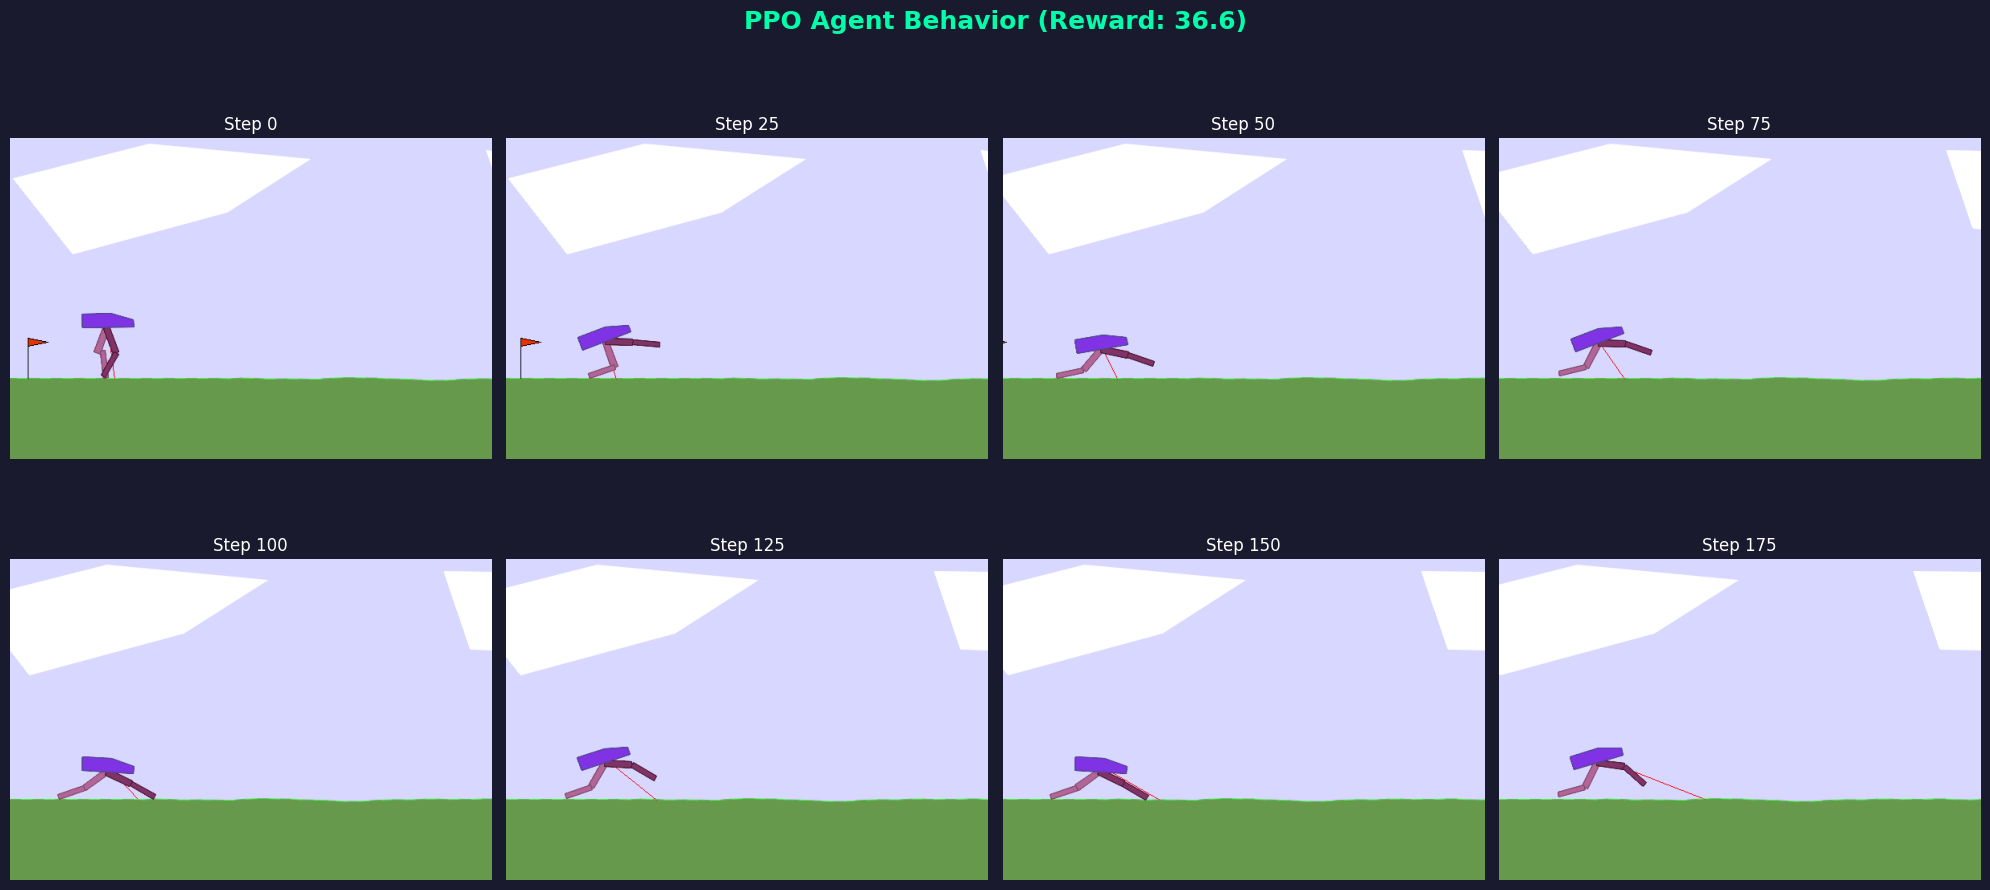


✓ Agent behavior montage saved!


In [11]:
# Create frame montage
if len(frames) >= 4:
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    fig.patch.set_facecolor('#1a1a2e')
    fig.suptitle(f'{best_algo} Agent Behavior (Reward: {total_reward:.1f})', 
                 fontsize=18, fontweight='bold', color='#00ffaa')
    
    for idx, ax in enumerate(axes.flat):
        if idx < len(frames):
            ax.imshow(frames[idx])
            ax.set_title(f'Step {idx * 25}', fontsize=12, color='white')
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig('agent_behavior.png', dpi=150, bbox_inches='tight', facecolor='#1a1a2e')
    plt.show()
    print("\n✓ Agent behavior montage saved!")
else:
    print("Not enough frames captured.")


## 11. Summary & Comparison


In [12]:
# Create summary table
summary_data = []
for algo_name in all_results.keys():
    results = all_results[algo_name]
    eval_res = evaluation_results[algo_name]
    final_reward = np.mean(results['rewards'][-5:]) if len(results['rewards']) >= 5 else (results['rewards'][-1] if results['rewards'] else 0)
    
    summary_data.append({
        'Algorithm': algo_name,
        'Final Training Reward': f"{final_reward:.2f}",
        'Evaluation Reward': f"{eval_res['mean_reward']:.2f} ± {eval_res['std_reward']:.2f}",
        'Training Time (s)': f"{results['training_time']:.1f}",
    })

summary_df = pd.DataFrame(summary_data)
print("\n📊 Algorithm Comparison Summary")
print("=" * 75)
print(summary_df.to_string(index=False))
print("=" * 75)



📊 Algorithm Comparison Summary
Algorithm Final Training Reward Evaluation Reward Training Time (s)
      SAC               -102.54    -102.00 ± 9.22             648.8
     DDPG               -132.42   -169.15 ± 19.30             351.4
      PPO                -71.33     116.29 ± 5.14             143.4
      TD3               -123.10    -106.86 ± 4.52             314.8


In [13]:
# Key findings
best_algo = max(evaluation_results.keys(), key=lambda x: evaluation_results[x]['mean_reward'])
fastest_algo = min(all_results.keys(), key=lambda x: all_results[x]['training_time'])
most_stable = min(evaluation_results.keys(), key=lambda x: evaluation_results[x]['std_reward'])

print("\n" + "="*60)
print("📈 KEY FINDINGS")
print("="*60)
print(f"\n🏆 Best Performing: {best_algo} (Reward: {evaluation_results[best_algo]['mean_reward']:.2f})")
print(f"⚡ Fastest Training: {fastest_algo} ({all_results[fastest_algo]['training_time']:.1f}s)")
print(f"🎯 Most Stable: {most_stable} (Std: {evaluation_results[most_stable]['std_reward']:.2f})")

print("\n" + "="*60)
print("📝 RECOMMENDATIONS")
print("="*60)
print("""
• SAC: Best sample efficiency for continuous control
• DDPG: Simple but effective for deterministic policies
• TD3: Improved DDPG with better stability  
• PPO: More robust but may need more samples

To improve results:
• Increase TOTAL_TIMESTEPS to 500k-1M
• Tune hyperparameters (learning rate, batch size)
• BipedalWalker-v3 is "solved" at 300+ reward
""")

print("\n✅ Project completed successfully!")



📈 KEY FINDINGS

🏆 Best Performing: PPO (Reward: 116.29)
⚡ Fastest Training: PPO (143.4s)
🎯 Most Stable: TD3 (Std: 4.52)

📝 RECOMMENDATIONS

• SAC: Best sample efficiency for continuous control
• DDPG: Simple but effective for deterministic policies
• TD3: Improved DDPG with better stability  
• PPO: More robust but may need more samples

To improve results:
• Increase TOTAL_TIMESTEPS to 500k-1M
• Tune hyperparameters (learning rate, batch size)
• BipedalWalker-v3 is "solved" at 300+ reward


✅ Project completed successfully!


---

## Appendix: Algorithm Pseudocode (Unfolded Algorithms)

### SAC (Soft Actor-Critic)
```
Initialize: policy π_θ, Q-functions Q_φ1, Q_φ2, target networks, replay buffer D

for each iteration:
    for each environment step:
        a_t ~ π_θ(a_t|s_t)           # Sample action from policy
        Store (s_t, a_t, r, s_{t+1}) in D
    
    for each gradient step:
        Sample batch from D
        y = r + γ(min(Q_φ'1, Q_φ'2) - α log π_θ(a'|s'))  # Soft target
        Update Q-functions: φ_i ← φ_i - λ_Q ∇_φi (Q_φi - y)²
        Update policy: θ ← θ - λ_π ∇_θ (α log π_θ(a|s) - min(Q_φ1, Q_φ2))
        Soft update targets: φ'_i ← τφ_i + (1-τ)φ'_i
```

### DDPG (Deep Deterministic Policy Gradient)
```
Initialize: actor μ_θ, critic Q_φ, target networks μ_θ', Q_φ', replay buffer D

for each episode:
    for each timestep:
        a_t = μ_θ(s_t) + ε  # Action with exploration noise
        Execute a_t, observe r_t, s_{t+1}
        Store (s_t, a_t, r_t, s_{t+1}) in D
        
        Sample minibatch from D
        y_i = r_i + γ Q_φ'(s_{i+1}, μ_θ'(s_{i+1}))  # Target value
        Update critic: φ ← φ - λ_Q ∇_φ (Q_φ(s,a) - y)²
        Update actor: θ ← θ + λ_μ ∇_a Q_φ(s,a)|_{a=μ_θ(s)} ∇_θ μ_θ(s)
        
        Soft update targets:
            θ' ← τθ + (1-τ)θ'
            φ' ← τφ + (1-τ)φ'
```

### PPO (Proximal Policy Optimization)
```
Initialize: policy π_θ, value function V_φ

for each iteration:
    Collect trajectories using π_θ
    Compute advantages Â_t using GAE:
        Â_t = δ_t + (γλ)δ_{t+1} + ... + (γλ)^{T-t+1}δ_{T-1}
        where δ_t = r_t + γV(s_{t+1}) - V(s_t)
    
    for k epochs:
        for each minibatch:
            r_t(θ) = π_θ(a|s) / π_θ_old(a|s)  # Probability ratio
            L_CLIP = min(r_t Â_t, clip(r_t, 1-ε, 1+ε) Â_t)
            Update policy: θ ← θ + ∇_θ L_CLIP
            Update value: φ ← φ - ∇_φ (V_φ(s) - V_target)²
```

### TD3 (Twin Delayed DDPG)
```
Initialize: actor π_θ, critics Q_φ1, Q_φ2, target networks, buffer D

for each timestep:
    a = π_θ(s) + ε, ε ~ N(0, σ)  # Exploration noise
    Store transition in D, sample batch
    
    # Target with clipped noise (target policy smoothing)
    ã = π_θ'(s') + clip(ε, -c, c), ε ~ N(0, σ̃)
    y = r + γ min(Q_φ'1(s', ã), Q_φ'2(s', ã))  # Twin critics
    
    # Update both critics
    φ_i ← φ_i - ∇_φi (Q_φi(s,a) - y)²
    
    if t mod d = 0:  # Delayed policy updates
        # Update actor using Q_φ1 only
        θ ← θ + ∇_θ Q_φ1(s, π_θ(s))
        
        # Soft update all targets
        θ' ← τθ + (1-τ)θ'
        φ'_i ← τφ_i + (1-τ)φ'_i
```
